In [1]:
# Load data
from sklearn.datasets import load_wine
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

d = load_wine()
x = d['data']
y = d['target']

y[y==2] = 1

# x = np.random.randn(100,2)*1+[4,5]
# x = np.concatenate([x, np.random.randn(100,2)*1+[-6, 5]])
# y=np.concatenate([np.zeros(100),np.ones(100)])

y[y==0]=-1

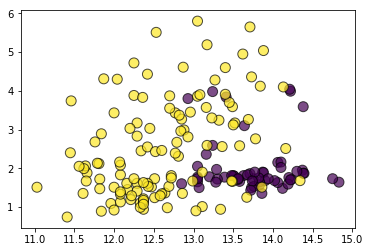

In [6]:
plt.scatter(x[:,0], x[:,1], c=y, alpha=0.7, edgecolors='k', s=100)

In [7]:
from scipy.optimize import linprog
# Impose sparsity by: |x|=x+ + x- & x = x+ - x- 
class lp_svm_sparse():
    def __init__(self):
        pass
    
    def get_mats(self, x, y, lamb, gamma):
        m, n = x.shape 
        # x+ (n), x-(n), r, epsilons(m), b(1)
        c = np.concatenate([gamma*np.ones(n), gamma*np.ones(n), [-1.0], lamb*np.ones(m), [0.0]]) # Objective: w, r, epsilons, b
        A = np.zeros((m+2*n, 2*n+2+m))
        b = np.zeros(m+2*n)        
        bounds = np.zeros((2, 2*n+2+m))
        
        # Inequality constraints
        for i in range(m):
            z = np.zeros(m)
            z[i] = -1.0
            A[i, :] = np.concatenate([-y[i]*x[i,:], y[i]*x[i,:], [1.0], z, [-y[i]]])
                
        for i in range(n):
            z = np.zeros(m)
            wwp_abs = np.zeros(2*n)
            wwp_abs[i] = 1.0
            wwp_abs[i+n] = -1.0            
            A[m+i, :] = np.concatenate([wwp_abs, [0.0], z, [0.0]])
            b[m+i] = 1.0
            
        for i in range(n):
            z = np.zeros(m)
            wwp_abs = np.zeros(2*n)
            wwp_abs[i] = -1.0
            wwp_abs[i+n] = 1.0            
            A[m+n+i, :] = np.concatenate([wwp_abs, [0.0], z, [0.0]])
            b[m+n+i] = 1.0
    
        bounds[0,:] = np.concatenate([n*[-np.inf], n*[-np.inf], [0.0], np.zeros(m), [-np.inf]])
        bounds[1,:] = np.concatenate([n*[np.inf], n*[np.inf], [np.inf], m*[np.inf], [np.inf]])  
#         A_eq = [] 
#         b_eq = []
        return c, A, b, tuple(map(tuple, bounds.T))
    
    def fit(self, x, y, lamb=0.5, gamma=.1):
        c, A, b, bounds = self.get_mats(x, y, lamb, gamma)
#         c, A, b, bounds = self.get_mats(x, y, p_w, lamb)
        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, options=dict(tol=1e-8))
#         res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, options=dict(tol=1e-8))
        
        m, n = x.shape
        self.wr = res.x[0:n]
        self.w = res.x[0:n]-res.x[n:2*n]
        self.b = res.x[-1]
        self.A = A
        self.c = c
        self.res = res
    
    def predict(self, x):
        return 2*(x.dot(self.w)+self.b>0)-1

In [8]:
from scipy.optimize import linprog
class lp_svm_sparse_1():
    def __init__(self):
        pass
    
    def get_mats(self, x, y, lamb, gamma):
        m, n = x.shape 
        c = np.concatenate([gamma*np.ones(n), gamma*np.ones(n), [-1.0], lamb*np.ones(m), [0.0]]) # Objective: w, r, epsilons, b
        A = np.zeros((m, 2*n+2+m))
        b = np.zeros(m)
        bounds = np.zeros((2, 2*n+2+m))
        for i in range(m):
            z = np.zeros(m)
            z[i] = -1.0
            A[i, :] = np.concatenate([-y[i]*x[i,:], -y[i]*x[i,:], [1.0], z, [-y[i]]])
                        
        bounds[0,:] = np.concatenate([-np.ones(n), [0.0], np.zeros(m), [-np.inf]])
        bounds[1,:] = np.concatenate([np.ones(n), [np.inf], m*[np.inf], [np.inf]])    
        return c, A, b, tuple(map(tuple, bounds.T))
    
    def fit(self, x, y, lamb=0.5, p_w=np.empty(0)):
        c, A, b, bounds = self.get_mats(x, y, lamb)
        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, options=dict(tol=1e-8))
        m, n = x.shape
        self.w = res.x[0:n]
        self.b = res.x[-1]
        self.A = A
        self.c = c
        self.epsilons = res.x[n+1:-1]
        self.r = res.x[n]
        self.res = res
    
    def predict(self, x):
        return 2*(x.dot(self.w)+self.b>0)-1

In [17]:
from sklearn.svm import LinearSVC
# l = LinearSVC(penalty='l1', dual=False)
# l.fit(x, y)
l = lp_svm_sparse()
l.fit(x, y, lamb=0.5, gamma=.1)    
print(l.predict(x)-y)

[ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  2  2  0  0  2  2  0  0
  2  2  0  0  2  0  0  0  0  2  0  2  0  0  0  0  0  0  0  2  0  2  0  0
  0  0  0  0  0  0  0  2  0  0  0 -2 -2  0  0  0  0 -2 -2  0  0 -2 -2  0
  0  0  0 -2 -2  0 -2  0  0 -2  0  0 -2  0  0  0  0  0 -2  0  0  0  0  0
  0 -2 -2  0 -2 -2  0  0  0  0 -2  0  0 -2  0  0  0  0  0  0  0  0 -2  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2 -2  0  0  0  0  0  0  0  0
 -2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]


In [18]:
print(l.predict(x))

[-1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1
  1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1
  1  1  1 -1 -1  1 -1  1  1 -1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1
  1 -1 -1  1 -1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1]


In [19]:
# l.coef_
l.w

array([ 1.        ,  0.58612495,  1.        ,  1.        ,  0.08887904,
        1.        ,  0.07475939,  0.        , -0.80586927, -0.04014256,
        0.        ,  0.17998588, -0.00903444])

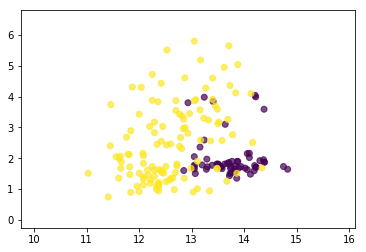

In [98]:
m, n = x.shape
# w = l.coef_[0]
# b = l.intercept_[0]
w = l.w
b = l.b

x_p = np.linspace(min(x[:,0])-1,max(x[:,0])+1,100)
y_p = (-x_p*w[0]-b)/w[1]
plt.scatter(x[:,0], x[:,1], c=y, alpha=0.7)
plt.plot(x_p, y_p, '-r')
plt.ylim([min(x[:,1])-1, max(x[:,1])+1])
plt.show()

In [46]:
l.coef_[0]

array([-0.39266256, -0.08972738])

In [100]:
l.res

     fun: -65.12569924864255
 message: 'Optimization failed. The problem appears to be unbounded.'
     nit: 330
   slack: array([ 2.16996717,  9.51466874,  3.55616383,  4.61340434,  0.        ,
        6.84669923,  7.82027593,  1.95379172,  5.88776171,  4.49648467,
        5.78437027,  6.35047489,  7.95702006, 10.12231975, 12.38958604,
        3.93414176,  0.        ,  0.        ,  7.98443909,  0.87900692,
        0.        ,  0.        ,  3.34354421,  3.40311284,  0.        ,
        0.        ,  5.85547509,  6.75135675,  0.        ,  4.67818415,
        0.        ,  5.24528067,  2.75277859,  0.        ,  1.01559308,
        0.        ,  2.33295441,  3.71409569,  5.88750107,  0.        ,
        0.59942047,  1.70565986,  4.52987517,  0.        ,  2.06964765,
        0.        ,  2.40790545,  3.69475714,  1.40225099,  4.25199777,
       11.61528574,  6.02765004,  5.42398164,  4.16911235,  2.62820017,
        0.        ,  1.09192463,  5.0700396 ,  4.73884007,  0.        ,
        0.   